# Trying to guestimate the count rate for Fe-55

In [55]:
from astropy.io import fits

In [56]:
cdte1_fits= '/Users/pet00184/FOXSI_Analysis/updated2026plotting/UMNCoolingTests/June232025/CdTe1Fe55/CdTe1/slim_foxsi_cdte1_run225_PATH2.fits.gz'
cdte3_fits = '/Users/pet00184/FOXSI_Analysis/updated2026plotting/UMNCoolingTests/June232025/CdTe3Fe55/CdTe3/slim_foxsi_cdte3_run213_PATH2.fits.gz'
cdte4_fits = '/Users/pet00184/FOXSI_Analysis/updated2026plotting/UMNCoolingTests/June262025/CdTe4Fe55/CdTe4/slim_foxsi_cdte4_run272_PATH2.fits.gz'
cdte5_fits = '/Users/pet00184/FOXSI_Analysis/updated2026plotting/UMNCoolingTests/June262025/CdTe5Fe55/CdTe5/slim_foxsi_cdte5_run264_PATH2.fits.gz'

In [57]:
cdte1_data = fits.open(cdte1_fits)[1].data
cdte3_data = fits.open(cdte3_fits)[1].data
cdte4_data = fits.open(cdte4_fits)[1].data
cdte5_data = fits.open(cdte5_fits)[1].data

## Step 1: find the count rates within the peak for each detector

define the peak ranges by looking at the spectra

In [58]:
peak_ranges = {
    'cdte1': [4,8],
    'cdte3': [4.5,8],
    'cdte4': [4.5, 8],
    'cdte5': [5, 8]
}

calculate the total runtimes (livetime corrected) of the data

In [59]:
import numpy as np

def calculate_runtime(cdte_data):
    livetime = cdte_data['livetime'] * 1e-8 #to get into seconds
    total_runtime = np.sum(livetime)
    return total_runtime

runtimes = {}

for cdte_name, cdte_data in zip(peak_ranges.keys(), [cdte1_data, cdte3_data, cdte4_data, cdte5_data]):
    runtime = calculate_runtime(cdte_data)
    runtimes[cdte_name] = runtime


get the amount of counts within the peak

In [60]:
peak_counts_al = {}
peak_counts_pt = {}

def calculate_peak_counts(cdte_data, cdte_name, peak_range):
    energy_mask_al = (cdte_data['al_merged_energy_list'][:,0] > peak_range[0]) & (cdte_data['al_merged_energy_list'][:,0] < peak_range[1])
    energy_mask_pt = (cdte_data['pt_merged_energy_list'][:,0] > peak_range[0]) & (cdte_data['pt_merged_energy_list'][:,0] < peak_range[1])
    masked_al_energy = cdte_data['al_merged_energy_list'][energy_mask_al]
    masked_pt_energy = cdte_data['pt_merged_energy_list'][energy_mask_pt]
    peak_counts_al[cdte_name] = len(masked_al_energy)
    peak_counts_pt[cdte_name] = len(masked_pt_energy)

for cdte_name, peak_range, cdte_data in zip(peak_ranges.keys(), peak_ranges.values(), [cdte1_data, cdte3_data, cdte4_data, cdte5_data]):
    calculate_peak_counts(cdte_data, cdte_name, peak_range)

calculate the count rates

In [61]:
count_rates = {'Al':{},
               'Pt':{}
               }

def calculate_count_rate(runtime, counts):
    return counts/runtime

for cdte_name, runtime, peak_count_al, peak_count_pt in zip(runtimes.keys(), runtimes.values(), peak_counts_al.values(), peak_counts_pt.values()):
    count_rates['Al'][cdte_name] = calculate_count_rate(runtime, peak_count_al)
    count_rates['Pt'][cdte_name] = calculate_count_rate(runtime, peak_count_pt)

In [62]:
count_rates

{'Al': {'cdte1': np.float64(10.539677338658583),
  'cdte3': np.float64(27.677584486913947),
  'cdte4': np.float64(28.790716910160253),
  'cdte5': np.float64(7.002020087875393)},
 'Pt': {'cdte1': np.float64(16.039118050877185),
  'cdte3': np.float64(48.599545541371086),
  'cdte4': np.float64(38.442932732646845),
  'cdte5': np.float64(7.194584810040641)}}

## Step 2: calculate the decay we have from the source

In [63]:
T12 = 2.737 #years
t_amassed = 0.68 #years

f_decay = 2**(-t_amassed/T12)
f_decay

0.8418019723426101

quick check: how long would it take to get 2,000 counts for each detector without attenuation?

In [78]:
def calculate_integration_times(rate):
    time = 5000/(rate * 0.84)
    return time/60

int_times = {'Al':{},
             'Pt': {}
             }

for rate, name in zip(count_rates['Al'].values(), runtimes.keys()):
    int_times['Al'][name] = calculate_integration_times(rate)
for rate, name in zip(count_rates['Pt'].values(), runtimes.keys()):
    int_times['Pt'][name] = calculate_integration_times(rate)

In [79]:
int_times

{'Al': {'cdte1': np.float64(9.412655247278709),
  'cdte3': np.float64(3.584357198990913),
  'cdte4': np.float64(3.4457755781461374),
  'cdte5': np.float64(14.168246871803985)},
 'Pt': {'cdte1': np.float64(6.1852745825337685),
  'cdte3': np.float64(2.041301993696594),
  'cdte4': np.float64(2.580613448414156),
  'cdte5': np.float64(13.789030475795979)}}

## Step 3: calculate the transmission from attenuation

In the python_test.py code, I did some calculations of the attenuation coefficients for Al with the .002 and .007 thicknesses, and got these numbers (values taken from NIST):

0.002 inch Al: 0.8455
0.007 inch Al: 0.555864

now, we also need to figure out how to get the pixelated attenuator stuff!!!

In [71]:
import response_tools.io.fetch_response_data as fetch
fetch.foxsi4_download_required(verbose=True)

import astropy.units as u
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import norm

import response_tools.attenuation as att
import response_tools.responses as responses

Retrieving response products from: http://foxsi.space.umn.edu/data/response/response-components/
Saving response products to: /Users/pet00184/FOXSI_Analysis/response-tools/response_tools/response-information
Found nothing new to download


In [72]:

# this is taken from Kris's python script
region = 0 #all regions checked and much the same
t5_rmf = responses.foxsi4_telescope5_rmf(region=region)
photon_mid_energies = (t5_rmf.input_energy_edges[:-1]+t5_rmf.input_energy_edges[1:])/2

pix = att.att_pixelated(photon_mid_energies, use_model=True)
mylar = att.att_al_mylar(photon_mid_energies)

Text(0.5, 0, 'Energy (keV)')

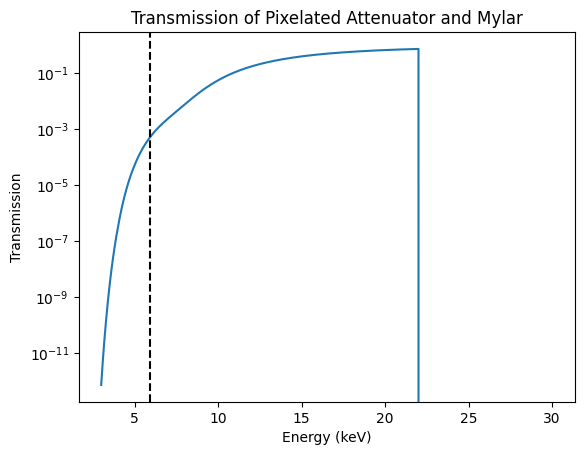

In [73]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 1)
ax.plot(pix.mid_energies, pix.transmissions*mylar.transmissions)
ax.axvline(5.9, c='k', ls='--')
ax.set_yscale('log')
ax.set_title('Transmission of Pixelated Attenuator and Mylar')
ax.set_ylabel('Transmission')
ax.set_xlabel('Energy (keV)')

In [74]:
overall_att = pix.transmissions*mylar.transmissions

overall_att[29]

<Quantity 0.00049617>

In [75]:
mylar.mid_energies[29]

<Quantity 5.9 keV>

So we can do a final calculation of the livetimes needed with all attenuation and source decay:

In [76]:
transmission_coeffs = {
    'cdte1': .0005,
    'cdte3': 0.846,
    'cdte4': 0.556,
    'cdte5': .0005,
}

def calculate_integration_times_withatt(rate, name):
    time = 5000/(rate * 0.84 * transmission_coeffs[name])
    return time/60

int_times_withatt = {'Al':{},
             'Pt': {}
             }

for rate, name in zip(count_rates['Al'].values(), runtimes.keys()):
    int_times_withatt['Al'][name] = calculate_integration_times_withatt(rate, name)
for rate, name in zip(count_rates['Pt'].values(), runtimes.keys()):
    int_times_withatt['Pt'][name] = calculate_integration_times_withatt(rate, name)

In [ ]:
int_times_withatt #in minutes

{'Al': {'cdte1': np.float64(18825.310494557416),
  'cdte3': np.float64(4.23682884041479),
  'cdte4': np.float64(6.197438090190894),
  'cdte5': np.float64(28336.493743607967)},
 'Pt': {'cdte1': np.float64(12370.549165067534),
  'cdte3': np.float64(2.4128865173718608),
  'cdte4': np.float64(4.641391094270064),
  'cdte5': np.float64(27578.060951591953)}}